## Corners, Local Feature Descriptors, Hough Transform (15pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this lab we will apply our knowledge in the lectures on Interest Points, Local Feature Descriptors and the Hough Transform.

### 1. Corners as Interest Points (5pts).
In this section we will implement a version of the Harris Corner Detection. You are going to detect the corners in Rice Hall. Note that you are not allowed to use any outside library other than the ones explicitly indicated for this question. The idea is for you to implement the Harris corner detector and a variant of it.

Image size:  (528, 940, 3)


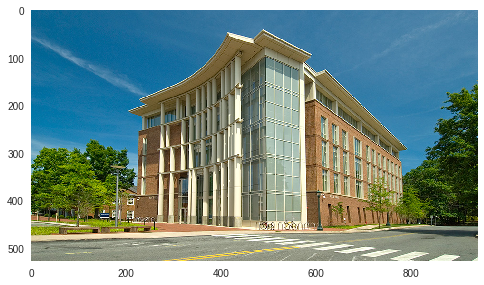

In [73]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img = img.astype('float') / 255

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid('off')
  plt.show()
  
display_image(img)

**1.1 ** Compute and display $I_x^2$, $I_y^2$, and $I_xI_y$ using Sobel operators. You are only allowed to use scipy.signal.convolve2d for any convolutional operations. Feel free to reuse your code from the previous assignment. (1pts)

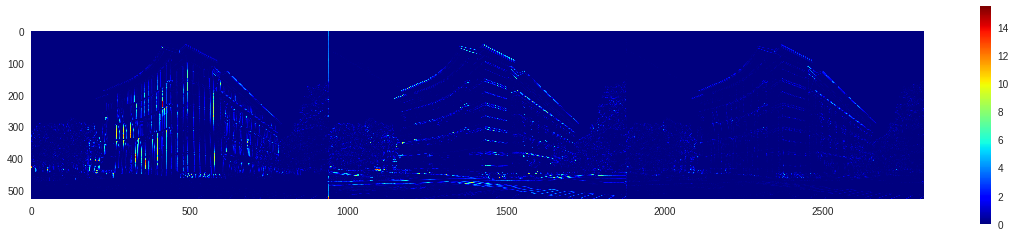

In [74]:
from scipy import signal
# Compute Ixx, Iyy and Ixy here.
sob_img = np.copy(img)
# Converting image to grayscale.
sob_img_float = sob_img.astype('float')
sob_img_gray = (sob_img_float[:, :, 0] + sob_img_float[:, :, 1] + sob_img_float[:, :, 2]) / 3.0

sobel_x=np.array([[1,0,-1],[2,0,-2],[1,0,-1],])
sobel_y=(sobel_x).T

Ix = sp.signal.convolve2d(sob_img_gray, sobel_x, 'same')
Iy = sp.signal.convolve2d(sob_img_gray, sobel_y, 'same')

Ixx=Ix**2
Iyy=Iy**2
Ixy=Ix*Iy
# print('Ixx: \n', Ixx)
# print('Iyy: \n', Iyy)
# print('Ixy: \n', Ixy)


# Plot Ixx, Iyy, Ixy.
plt.figure(figsize=(20,4))
plt.imshow(np.concatenate((Ixx, Iyy, np.abs(Ixy)), axis = 1), 
           cmap =  'jet')
plt.colorbar()
plt.grid('off')
plt.show()

**1.2** Show side by side the input image with the response map R computed using the original Harris detector with $\alpha=0.05$, and using the Harmonic mean formula proposed by Szeliski. Use a window/patch size of 12x12 to define the momentum matrix M. (2pts).

In [0]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


(528, 940)


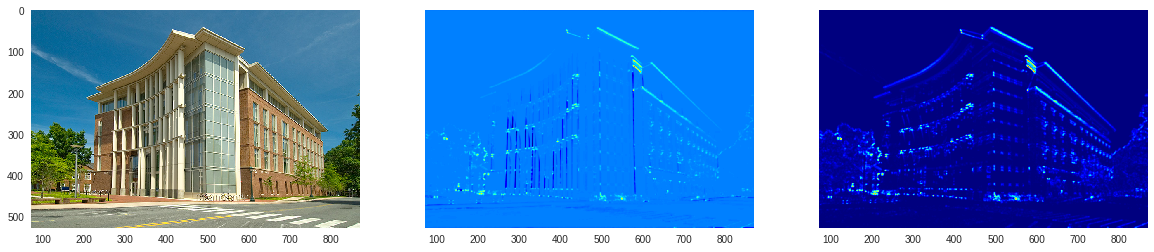

In [75]:
# My images looks bluer, but all the lines are highlighted. 
# I hope this will not be a problem.


# Compute the Rmap and RHarmonicMap map responses.

from scipy import signal
from scipy import *

# Returns a normalized 2D gauss kernel array for convolutions 
def gauss_kernel(size, sizey = None):
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

# returns x and y derivatives of a 2D gauss kernel array for convolutions
def gauss_derivative_kernels(size, sizey=None):
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]

    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 

    return gx,gy

# returns x and y derivatives of an image using gaussian 
# derivative filters of size n. The optional argument 
# ny allows for a different size in the y direction.
def gauss_derivatives(im, n, ny=None):
    gx,gy = gauss_derivative_kernels(n, sizey=ny)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    return imx,imy


def computeHarmonic(image):
    #get derivatives
    imx, imy = gauss_derivatives(image, 3)

    #get kernel for blurring
    gauss = gauss_kernel(3)

    Wxx = signal.convolve(imx*imx, gauss, mode='same')
    Wxy = signal.convolve(imx*imy, gauss, mode='same')
    Wyy = signal.convolve(imy*imy, gauss, mode='same')
    #determinant and trace
    Wdet = Wxx*Wyy
    Wtr = Wxx + Wyy
    
    return (Wdet/Wtr)
  
def computeHarrisR(image):
    #get derivatives
    imx, imy = gauss_derivatives(image, 3)

    #get kernel for blurring
    gauss = gauss_kernel(3)

    Wxx = signal.convolve(imx*imx, gauss, mode='same')
    Wxy = signal.convolve(imx*imy, gauss, mode='same')
    Wyy = signal.convolve(imy*imy, gauss, mode='same')
    #determinant and trace
    Wdet = Wxx*Wyy
    Wtr = Wxx + Wyy
    
    return (Wdet - 0.05* Wtr**2)

RMap = computeHarrisR(sob_img_gray)
RHarmonicMap=computeHarmonic(sob_img_gray)
print(RMap.shape)
# Plot Harris response outputs.
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 4))
ax1.imshow(img);ax1.grid('off')
ax2.imshow(RMap, cmap = 'jet'); ax2.grid('off')
ax3.imshow(RHarmonicMap, cmap ='jet'); ax3.grid('off');

**1.3** Perform non-max supression on the outputs obtained in the previous step so that you get a list of pixels corresponding to corners for each method. Feel free to use any  method you can think of but the general idea is to leave only one point per corner and no two points with high values should be together. An easy way is to just define a minimum distance between corners of 5 pixels. The only pixels surviving (non-zero) after non-max should be the ones that a) pass a threshold (which you are free to define), and b) are the maximum pixel within their neighborhood. I am including outputs as an example of what it should more or less look like at the end. (2pts).

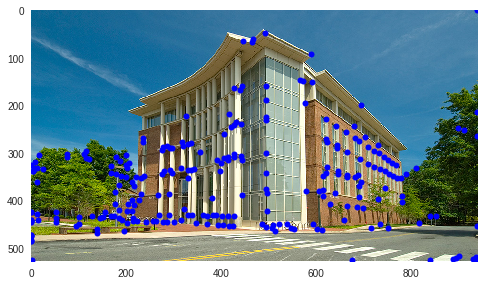

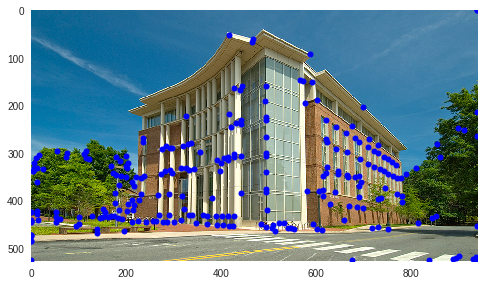

In [77]:
def nonmax(RMap):
  # Non-max supression and thresholding function.
  nonmax_RMap=np.copy(RMap)
  #check for extreme values
  min_sh = nonmax_RMap<percentile(nonmax_RMap,99) 
  #turn unqualified pixels to 0s
  nonmax_RMap[min_sh]=0 
# An easy way is to just define a minimum distance between corners of 5 pixels. 
# The only pixels surviving (non-zero) after non-max should be the ones that 
# a) pass a threshold (which you are free to define)
# , and b) are the maximum pixel within their neighborhood. 
  for i in range(528):
    for j in range(940):
      if nonmax_RMap[i][j]>0:
        nonmax_RMap[i-5:i+5,j+1:j+5]=0
        nonmax_RMap[i-5:i+5,j-5:j-1]=0
        nonmax_RMap[i+1:i+5,j-5:j+5]=0
        nonmax_RMap[i-5:i-1,j-5:j+5]=0
  return nonmax_RMap

# np.nonzero extracts 2d coordinates of non-zero elements.
ys1, xs1 = np.nonzero(nonmax(RMap))
ys2, xs2 = np.nonzero(nonmax(RHarmonicMap))

# Method 1: Harris operator original score.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs1, ys1, '.b', markersize=12)
ax.grid('off')

# Method 2: Szeliski's Harmonic mean.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs2, ys2, '.b', markersize=12)
ax.grid('off')

**Final Comments:** What happens if you rotate the image? Will it still detect the same corners? What happens if you resize the image? Will it detect the same corners? When will you get more corners detected, if you resize up or resize down the image?

### 2. Image Retrieval by Matching Local Feature Descriptors (5pts).

In this section we will compute interest points using OpenCV's implementation of the DoG extrema operator, which unlike the Harris operator produces points that are also scale invariant, and then we will also use OpenCV's implementation of the SIFT feature descriptor. The task will be then to aggreate these features across the image to perform retrieval, and build a simple search/retrieval application.

In [9]:
# These lines will install OpenCV in Google's Colaboratory environment 
# so only run once.
# Also you might need to do Runtime -> Restart runtime after running this.
!pip install -q opencv-python && apt -qq update && apt -qq install -y libsm6 libxext6
!pip install opencv-contrib-python
# Please clear the output of this cell before submitting your assignment as
# it will generate a bunch of logging output.

35 packages can be upgraded. Run 'apt list --upgradable' to see them.
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
    100% |████████████████████████████████| 30.5MB 46kB/s 


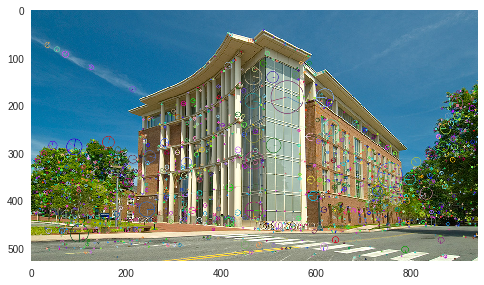

In [78]:
import cv2  # After running the above cell this should work.
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')

# Convert to grayscale using OpenCV's function.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Create the SIFT interest point and feature descriptor extractor object.
sift = cv2.xfeatures2d.SIFT_create()

# Detect the interest points (keypoints).
keypoints = sift.detect(gray, None)
out =  cv2.drawKeypoints(img, keypoints, img, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(out); plt.grid('off')
plt.show()


**2.1** Show the output of the SIFT descriptor the Rice Hall image at three different resolutions (0.7 image size, 0.5 image size, and 0.25 image size). Feel free to use cv2.resize. This is to make sure you have everything installed. (1pts)

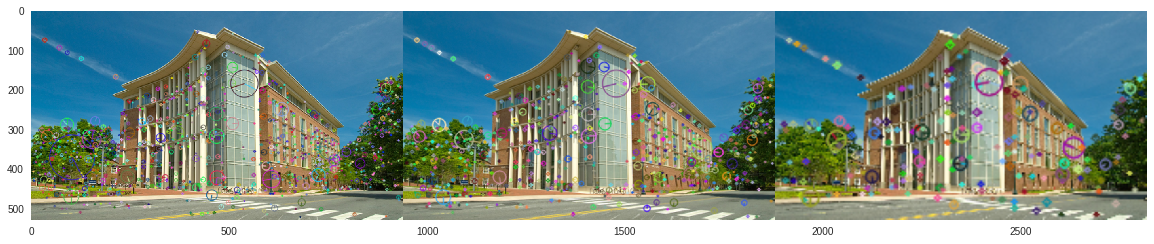

In [79]:
# Compute keypoint images for the three resized versions here.
import cv2  # After running the above cell this should work.
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import math

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')

img1=cv2.resize(img,(0,0),fx=0.7,fy=0.7, interpolation = cv2.INTER_LINEAR)
img2=cv2.resize(img,(0,0),fx=0.5,fy=0.5, interpolation = cv2.INTER_LINEAR)
img3=cv2.resize(img,(0,0),fx=0.25,fy=0.25, interpolation = cv2.INTER_LINEAR)

# Convert to grayscale using OpenCV's function.
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
gray3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

# Create the SIFT interest point and feature descriptor extractor object.
sift = cv2.xfeatures2d.SIFT_create()

# Detect the interest points (keypoints).
keypoints1 = sift.detect(gray1, None)
keypoints2 = sift.detect(gray2, None)
keypoints3 = sift.detect(gray3, None)

out1 =  cv2.drawKeypoints(img1, keypoints1, img1, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
out2 =  cv2.drawKeypoints(img2, keypoints2, img2, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
out3 =  cv2.drawKeypoints(img3, keypoints3, img3, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
h, w, _ = img.shape
# Display
out1 = cv2.resize(out1, (w,h))
out2 = cv2.resize(out2, (w,h))
out3 = cv2.resize(out3, (w,h))
plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate((out1, out2, out3), axis=1)); plt.grid('off')
plt.show()

**Final Comments:** Actually it is not very suprising that the keypoints are similar in all three images above because the DoG extrema operator is run at several resolutions and the maxima is taken across resolutions.

**2.2** In this section we will use two images of Rice Hall and try to match as many corresponding keypoints. For this task we will use **cv.detectAndCompute()**, which will compute the keypoints but also a 128-dimensional vector representing the SIFT feature descriptor for each keypoint. First, compute a matrix containing the distances between each pair of SIFT descriptors (s1, s2) where s1 is a descriptor for a keypoing in uvacs.jpg and s2 is a SIFT descriptor for a keypoing in uvacs2.jpg. Feel free to use any distance function that you want (2pts).



In [0]:
from cv2 import Feature2D
import numpy as np
import cv2
from matplotlib import pyplot as plt
# Try maybe downloading the images in case the CS webserver goes down.
img_url1 = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img_url2 = 'http://www.cs.virginia.edu/~vicente/vision/uvacs2.jpg'

# Read images.
img1 = sp.misc.imread(urlopen(img_url1), mode = 'RGB')
img2 = sp.misc.imread(urlopen(img_url2), mode = 'RGB')

# Create the SIFT interest point and feature descriptor extractor object.
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

dis = []
dis = sp.spatial.distance_matrix(des1, des2, p=1, threshold=1000000)

**2.3** Find the 80 closest pairs (s1, s2) and their corresponding keypoint locations on each image. Then plot their corresponding matches as in the picture provided below. Notice you might need to resize the second image to match the dimensions of the first image to put them side by side. Feel free to use OpenCVs cv2.resize function but not any of the matching or plotting functions included in OpenCV. Also, note that the points that you will obtain might be slightly different than the ones shown in the example, as these were obtained using an L1-distance (2pts).

528 940 500 774
size of img1: (528, 940, 3)
size of img2_resized:  (528, 940, 3)


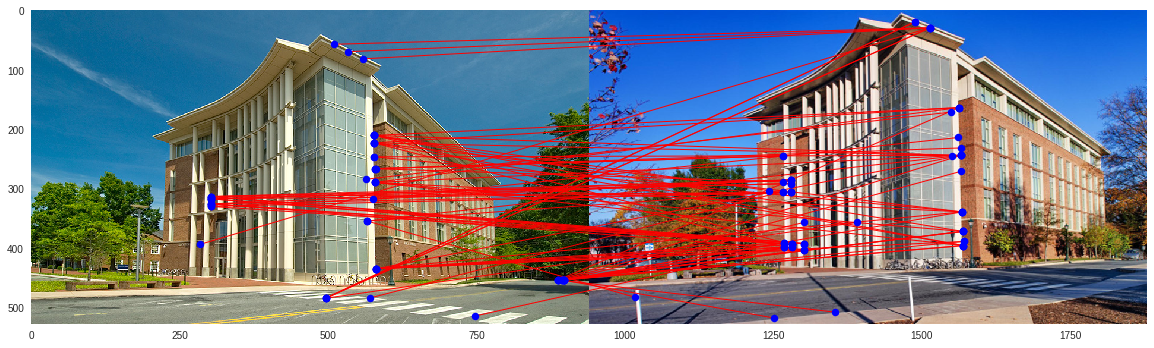

In [87]:
# 1. Extract the indices with the 100 smallest distances.
newKpt = []
for i in range(len(des1)):
  for j in range(len(des2)):
    newKpt.append([(i,j),dis[i][j]])
newKpt = np.asarray(newKpt)
newKpt = newKpt[newKpt[:,1].argsort()]
newDis = newKpt[:80][:,0]

#get the matching keypoints for img1 and img2
pts1=[]
pts2=[]
for i in range (80):
  k1,k2 = newDis[i]
  pts1.append((kp1[k1].pt))
  pts2.append((kp2[k2].pt))
pts1 = np.asmatrix(pts1)
pts2 = np.asmatrix(pts2)

# 1. Resize img2 to img1 size.
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
Rw = w1/w2
Rh = h1/h2
print(h1,w1,h2,w2)
img2_resized = cv2.resize(img2,(0,0),fx=w1/w2, fy=h1/h2)
print("size of img1:", img1.shape)
print("size of img2_resized: ", img2_resized.shape)

# 2. Project img2 pts to img1 coordinates.
fig, ax = plt.subplots(figsize=(20,40))
# Plot imges where out is np.concatenate((img1, img2_resized), axis=1)
out = np.concatenate((img1,img2_resized),axis=1)
ax.imshow(out, interpolation='nearest', cmap=plt.cm.gray)
for i in range(pts1.shape[0]): # Plot lines between matching pts.
  ax.plot([pts1[i, 0], w1+pts2[i, 0]*Rw], 
          [pts1[i, 1], pts2[i, 1]*Rh], 'r-', linewidth=1)
ax.plot(pts1[:, 0], pts1[:, 1], '.b', markersize=15)  # Plot pts img1.
ax.plot(w1+pts2[:, 0]*Rw, pts2[:, 1]*Rh, '.b', markersize=15)  # Plot pts img2.
ax.grid('off')

**Final Comments:** Robust matching algorithms will provide one-to-one mappings, unlike the output provided with this assignment. How could you implement that? Also, the naive implementation of the distance computations will be extremely slow, how would you accelerate the computation of these matches? Can you think of how geometry constraints and consistency could be used to obtain better matches? How could this type of matching be useful in an application?

### 3. Hough Transform for line detection (5pts).
In this section we will perform line detection by implementing the Hough Transform.

Image size:  (528, 940, 3)


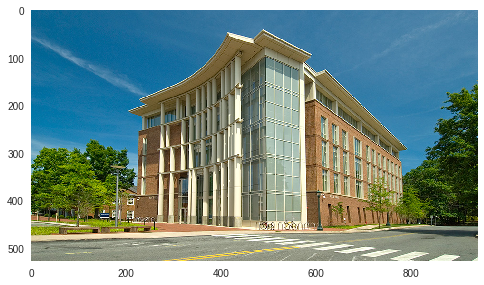

In [88]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img = img.astype('float') / 255

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid('off')
  plt.show()
  
display_image(img)

**3.1** Use the Hough Transform to find all the lines in the image. Show the Hough Transform for the Rice Hall image (2pts).

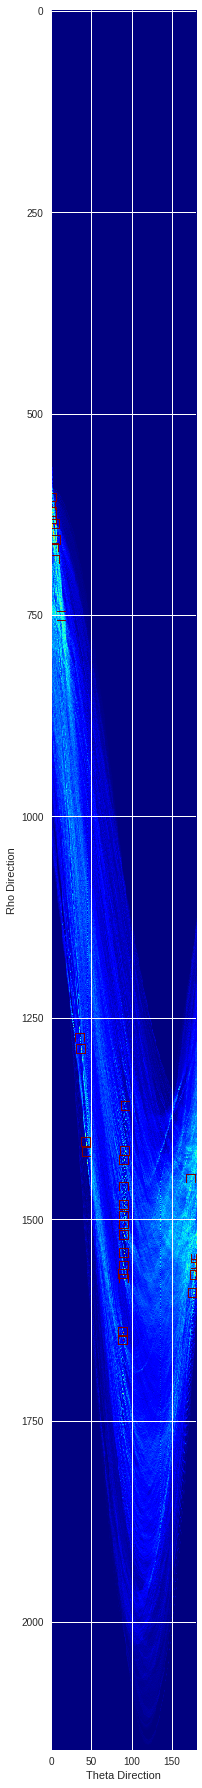

In [89]:
# Your code goes here. no sample output provided.
import numpy as np
import cv2
import scipy as sp
import matplotlib.pyplot as plt
from urllib.request import urlopen

img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#use blurred image to reduce noise in the image
img_blurred = cv2.GaussianBlur(img_gray, (5, 5), 1.5)
# find Canny Edges
canny_edges = cv2.Canny(img_blurred, 100, 200)


# This function will build the Hough Accumulator for a given image
def houghLineAc(img, rho_resolution=1, theta_resolution=1):
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))
 
    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes
 
    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]
 
        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1
 
    return H, rhos, thetas
 

def houghPeak(H, num_peaks, threshold=0, nhood_size=3):
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # re-map to shape of H
        indicies.append(H1_idx)
 
        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
    
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1
 
        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1
          
        # change datatype to int to run the for loop
        min_x=int(min_x)
        min_y=int(min_y)
        max_x=int(max_x)
        max_y=int(max_y)
        
        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0
 
                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255
 
    # return the indicies and the original Hough space with selected points
    return indicies, H
  
# This funciton is used to plot the Hough Accumulator
def plotHoughAc(H, plot_title='Hough Accumulator Plot'):
    fig = plt.figure(figsize=(25, 25))
    fig.canvas.set_window_title(plot_title)
         
    plt.imshow(H, cmap='jet')
 
    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()
 
  
# run houghLineAc on the canny_edges image
H, rhos, thetas = houghLineAc(canny_edges)
indicies, H = houghPeak(H, 35, nhood_size=11) # find peaks
plotHoughAc(H) 


**3.2** Find the peaks in the Hough Transform computed in the previous step and plot the original images with red lines overlaid showing the detected lines (3pts).

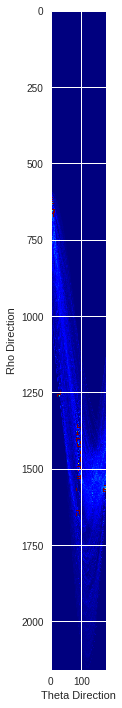

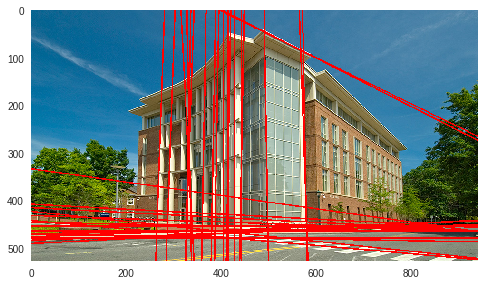

In [90]:
# Your code goes here. no sample output provided.
import numpy as np
import cv2
import scipy as sp
import matplotlib.pyplot as plt
from urllib.request import urlopen

img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#use blurred image to reduce noise in the image
img_blurred = cv2.GaussianBlur(img_blurred, (5, 5), 1.5)
 
# find Canny Edges
canny_edges = cv2.Canny(img_blurred, 100, 200)

# This function will build the Hough Accumulator for a given image
def houghLineAc(img, rho_resolution=1, theta_resolution=1):
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))
 
    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes
 
    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]
 
        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1
 
    return H, rhos, thetas
 

# This function returns the indicies of the accumulator array H that
# correspond to a local maxima.  
# If threshold is active all values less than this value will be ignored,
# if neighborhood_size is greater than (1, 1) 
# this number of indicies around the maximum will be surpessed.
def houghPeak(H, num_peaks, threshold=0, nhood_size=3):
    # loop through number of peaks
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # re-map to shape of H
        indicies.append(H1_idx)
 
        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
    
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1
 
        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1
          
        # change datatype to int to run the for loop
        min_x=int(min_x)
        min_y=int(min_y)
        max_x=int(max_x)
        max_y=int(max_y)
        
        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0
 
                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255
 
    # return the indicies and the original Hough space with selected points
    return indicies, H
 
 
# This funciton is used to plot the Hough Accumulator
def plotHoughAc(H, plot_title='Hough Accumulator Plot'):
    fig = plt.figure(figsize=(10, 10))
    fig.canvas.set_window_title(plot_title)
         
    plt.imshow(H, cmap='jet')
 
    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()
 
 
# This function takes indicies a rhos table and thetas table and draws
# lines on the input images that correspond to these values.
def drawLine(img, indicies, rhos, thetas):
    for i in range(len(indicies)):
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
 
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
 
 
# run houghLineAc on the shapes canny_edges image
H, rhos, thetas = houghLineAc(canny_edges)
indicies, H = houghPeak(H, 35, nhood_size=11) # find peaks
plotHoughAc(H) # plot hough space, brighter spots have higher votes
drawLine(img, indicies, rhos, thetas)
 
# Show image with manual Hough Transform Lines
cv2.imwrite('houghlines2.jpg',img)
plt.figure()
plt.imshow(img); plt.grid('off')
plt.show()


Prof's output is in lecture slide


**Final Comments:** The Hough Transform detects lines, how would you modify the algorithm to find instead line segments? 